# Linear Convection in 1D

ME469 - Computational Methods in Fluid Dynamics - Stanford University

Example #1

These examples are provided as part of the ME469 class (Spring 2018).

For comments or corrections, please contact jops at stanford dot edu

## Objective
Study the convergence rate of the solution to the linear convection equation using different finite difference schemes 

We wish to solve the transport of a contaminant $\phi$ in time. The mathematical model chosen is 1D linear convection equation using explicit finite difference schemes

$$\frac{\partial \phi} {\partial t} + u\frac{\partial \phi} {\partial x}=0$$

$\phi$ is a scalar quantity (i.e. the concentration of a pollutant - defined in parts-per-million). We seek a solution using different numerical discretization.
Let's first define the exact solution, which is simply $\phi(t,x)=\phi_0(x-u t)$ where $\phi_0(x)$ is the initial condition, and $u$ is a given convection velocity.

The numerical solution is defined as $\phi(x,t) \approx \phi(x_i,t^n)= \phi^n_i$ on  a uniform grid consisting of $nno+1$ nodes. $x_0$ and $x_{nno}$ are the left and right boundaries, respectively. $x_1,x_2,\cdots,x_{nno-1}$ are the internal nodes.

In [2]:
#set things up
import numpy  as np                       
import pylab as pl
import time, sys  
%matplotlib inline 

### Let's get started
Set physical and numerical parameters for the problem, and define a suitable initiation condition

In [3]:
u = 1.0         # convection speed [m/s]
L = 2.0         # length of the domain (in x) [m]
T = 0.1         # time integration window [s]
cfl = 0.1       # keep it low to ensure stability 
periodic = 0    # periodicity on/off 

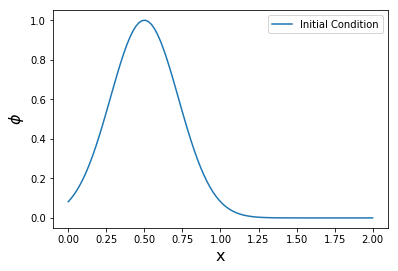

In [27]:
# define initial condition   
def ic(x):
    # initial distribution is a gaussian 
    xcenter = 0.5   # location of the gaussian center
    sharpen = 10.0  # increase to sharpen the gaussian
    phi_ic = np.exp(-sharpen*(x - xcenter)**2) #+!
    return phi_ic

# plot the initial condition to check that is what you expect...
def ic_plot():
    x = np.linspace(0,L,100)
    phi = np.zeros(100)  
    for i in range(100):
        phi[i]=ic(x[i])
    pl.clf()
    # make sure axis have labels and you include a legend
    pl.plot(x,phi, '-',label='Initial Condition')
    pl.legend()
    pl.xlabel("x",fontsize=16)  
    pl.ylabel(r"$\phi $",fontsize=16)
   
ic_plot()

Some utility functions that will be useful later

In [17]:
# set initial condition   
def initialize(nno,x,phi):
    for i in range(nno):
        phi[i]=ic(x[i])
    #check that the initial condition is 1 at x=0
    #print "Initial Condition @ left = ",phi[0]

# compute errors
def compute_exact(nno,time,x,phi_exact):
    time_shift = time
    if periodic and time*u > L:
        a = divmod(time,L/u)
        time_shift = a[1]
    for i in range(nno):
        phi_exact[i]=ic(x[i]-u*time_shift)

# plot the solution and compare to the exact one
def plot_solution(nno,x,phi,phi_exact):
    pl.clf()
    pl.plot(x,phi, '-',label='Computational')
    pl.plot(x, phi_exact, 'bs', label='Analytical')
    pl.xlabel("x",fontsize=16)  
    pl.ylabel(r"$\phi $",fontsize=16)
    pl.legend()

# compute the L2 norm of the error
def compute_error(nno,dx,phi,phi_exact):
    error = np.zeros(nno) #initialize
    for i in range(nno):
        error[i]=(phi[i]-phi_exact[i])
    my_norm = np.sqrt(dx*np.sum(error[1:nno-1]**2))     
    return my_norm

## The meat...
Define the discretization schemes - explicit finite difference stencils

We consider the upwind scheme

$$ \phi^{n+1}_i = \phi^n_i - \frac{u \Delta t}{\Delta x} \left( \phi_i^n - \phi_{i-1}^n \right)$$

and the Lax-Wendroff scheme

$$ \phi^{n+1}_i = \phi^n_i - \frac{u \Delta t}{2 \Delta x} \left( \phi_{i+1}^n - \phi_{i-1}^n \right) + \left( \frac{u \Delta t}{\Delta x} \right)^2 \left( \phi_{i+1}^n + \phi_{i-1}^n - 2\phi_i^n \right) $$

In [18]:
# First Order Upwind
def update_upwind(nno,dx,dt,phi):
    phi_old = phi.copy() 
    for i in range(1, nno-1):
        im = i-1
        phi[i] = phi_old[i]-u*dt/dx*(phi_old[i] - phi_old[im])

# Lax Wendroff
def update_laxwendroff(nno,dx,dt,phi):
    phi_old = phi.copy() 
    for i in range(1, nno-1):
        im = i-1
        ip = i+1
        phi[i] = phi_old[i]-0.5*u*dt/dx*((phi_old[ip]-phi_old[im])
                  -u*dt/dx*(-2.*phi_old[i]+phi_old[im]+phi_old[ip]))

# add your own...

Boundary conditions and the actual time integration loop

In [19]:
# set boundary condition (only for periodicity, otherwise the IC is OK)
def bc(nno,x,phi,time):
    if (periodic):
        phi[0]=phi[nno-2] #apply periodicity @ x=0
        phi[nno-1]=phi[1] #apply periodicity @ x=L
    else:
        phi[0]=ic(x[0]-u*time) #ncross the right boundary
        #phi[nno-1]=phi[nno-2] #zero-gradient?
        phi[nno-1]=ic(x[nno-1]-u*time) #cross the right boundary
            
# solve the PDE
def solve(nno,scheme="upwind",plot=1):  
    #by default use upwind and plot solution
    dx = L / (nno-1)    # spacing of the nodes
    x = np.linspace(0,L,nno)  #grid generation!
    phi = np.zeros(nno)  
    phi_exact = np.zeros(nno)  
    initialize(nno,x,phi) #initialize
    time = 0
    nts = 0
    dt = cfl*dx/u
    while time < T:  #integrate up to time T
        bc(nno,x,phi,time)
        nts = nts + 1
        time = time + dt  
        # update the solution with a finite difference scheme (explicit)
        if scheme == "upwind": 
            update_upwind(nno,dx,dt,phi)
        elif scheme == "laxwendroff":
            update_laxwendroff(nno,dx,dt,phi)
    # compare the solution with the exact and compute the L2 norm
    compute_exact(nno,time,x,phi_exact)
    enorm = compute_error(nno,dx,phi,phi_exact)
    if plot:
        plot_solution(nno,x,phi,phi_exact)
    return dx,enorm

## Let's compute something
Start with upwind 

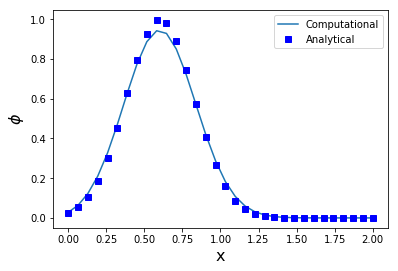

In [20]:
none, none = solve(32,"upwind",1)

Now Lax-Wendroff

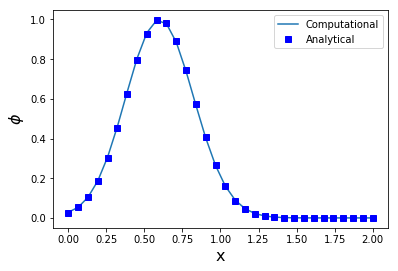

In [21]:
none, none = solve(32,"laxwendroff",1)

## Grid Convergence Study
Perform a quantitative analysis of the error. Using multiple grids and compare the L2 norm reduction. 

In [22]:
# set up a sequence of grids
ngrids = 6
n = [16,32,64,128,256,524]
delta = np.zeros(ngrids)
l2_upwind = np.zeros(ngrids)
l2_laxwendroff = np.zeros(ngrids)
nr = np.array(n, dtype=np.float64)  # make this real for plotting

# perform the simulations on each grid with different FD schemes
for ig in range(ngrids):
    delta[ig],l2_upwind[ig] = solve(n[ig],"upwind",0)
    delta[ig],l2_laxwendroff[ig] = solve(n[ig],"laxwendroff",0)
    print "Grid ",ig," Delta = ",delta[ig]," Error =",l2_upwind[ig],l2_laxwendroff[ig]

Grid  0  Delta =  0.133333333333  Error = 0.0594241582858 0.0221426390831
Grid  1  Delta =  0.0645161290323  Error = 0.0300105821893 0.0053153852187
Grid  2  Delta =  0.031746031746  Error = 0.0151003025064 0.00128373310695
Grid  3  Delta =  0.0157480314961  Error = 0.00757543427818 0.000314431525579
Grid  4  Delta =  0.0078431372549  Error = 0.00379419589414 7.774865555e-05
Grid  5  Delta =  0.0038240917782  Error = 0.00185529987558 1.84497597747e-05


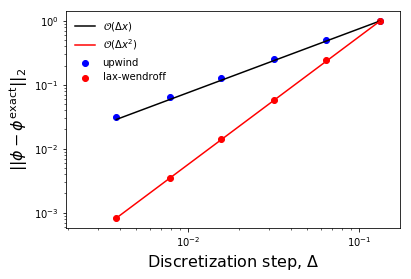

In [23]:
# plot the classical convergence diagram with first & second order slopes
pl.clf()
pl.scatter(delta, l2_upwind/l2_upwind[0],color="b", label="upwind")
pl.scatter(delta, l2_laxwendroff/l2_laxwendroff[0],color="r", label="lax-wendroff")
pl.plot(delta,(delta/delta[0]),color="k",label=r"$\mathcal{O}(\Delta x)$")
pl.plot(delta,((delta/delta[0])**2),color="r",label=r"$\mathcal{O}(\Delta x^2)$")
ax = pl.gca()
ax.set_xscale('log')
ax.set_yscale('log')
pl.xlabel(r"Discretization step, $\Delta$",fontsize=16)
pl.ylabel(r"$\|| \phi - \phi^\mathrm{exact} \||_2$",fontsize=16)
pl.legend(frameon=False);

## Further work
Change the position and the spread of the gaussian initial condition and see what happens to the accuracy